# Data Exploration

## Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go 
import seaborn as sns

In [2]:
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from dvc_helper import DvcHelper
from df_overview import DfOverview
from df_cleaner import DfCleaner
from df_outlier import DfOutlier
import vis_seaborn as vis_seaborn
import vis_plotly as vis_plotly

2021-07-27 07:13:12,813 — DfOverview — DEBUG — Loaded successfully!
2021-07-27 07:13:12,852 — DfCleaner — DEBUG — Loaded successfully!
2021-07-27 07:13:12,860 — DfOutlier — DEBUG — Loaded successfully!


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


class VisSeaborn():

  def __init__(self):
    pass

  def single_plot(self, plot, title, x_labels, y_labels, figsize):
      fig, ax = plt.subplots(figsize=figsize)
      def _ax(__, _): return ax
      plot(0, 0, _ax)
      plt.title(title, fontsize=15, fontweight='bold')
      plt.xlabel(x_labels[0], fontsize=14)
      plt.ylabel(y_labels[0], fontsize=14)
      fig.show()

  def vertical_plot(self, plot, rows, title, subtitles, x_labels, y_labels, figsize):
    fig, ax = plt.subplots(rows, 1, sharex=True, figsize=figsize)
    def _ax(x, _): return ax[x]
    for r in range(rows):
      ax[r].set_title(subtitles[r])
      ax[r].set(xlabel=x_labels[r], ylabel='')
      plot(r, 0, _ax)
    fig.suptitle(title, fontsize=15, fontweight='bold')
    fig.subplots_adjust(hspace=0.2)
    fig.show()

  def horizontal_plot(self, plot, cols, title, subtitles, x_labels, y_labels, figsize):
    fig, ax = plt.subplots(1, cols, sharex=True, figsize=figsize)
    def _ax(_, y): return ax[y]
    for c in range(cols):
      ax[c].set_title(subtitles[c])
      ax[c].set(xlabel='', ylabel=y_labels[c])
      plot(0, c, _ax)
    fig.suptitle(title, fontsize=15, fontweight='bold')
    fig.subplots_adjust(wspace=0.2)
    fig.show()

  def square_plots(self, plot, rows, cols, title, subtitles, x_labels, y_labels, figsize):
    fig, ax = plt.subplots(rows, cols, sharex=True, figsize=figsize)
    def _ax(x, y): return ax[x, y]
    for r in range(rows):
      for c in range(cols):
        ax[r, c].set_title(subtitles[(r * cols) + c])
        ax[r, c].set(xlabel=x_labels[(r * cols) + c], ylabel=y_labels[(r * cols) + c])
        plot(r, c, _ax)
    fig.suptitle(title, fontsize=15, fontweight='bold')
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    fig.show()

  def subplots(self, plot, rows, cols, title, subtitles, x_labels, y_labels, figsize):
    if(subtitles == ""):
      subtitles = [""] * rows * cols
    if(x_labels == ""):
      x_labels = [""] * rows * cols
    if(y_labels == ""):
      y_labels = [""] * rows * cols

    if(rows == 1 and cols == 1):
      return self.single_plot(plot, title, x_labels, y_labels, figsize)
    if(rows == 1):
      return self.horizontal_plot(plot, cols, title, subtitles, x_labels, y_labels, figsize)
    elif(cols == 1):
      return self.vertical_plot(plot, rows, title, subtitles, x_labels, y_labels, figsize)
    else:
      return self.square_plots(plot, rows, cols, title, subtitles, x_labels, y_labels, figsize)

  def boxplot(self, df, y_value, title="", subtitles="", rows=1, cols=1, x_labels="", y_labels="", figsize=(8, 6)):
    def plot(r, c, ax): return sns.boxplot(y=df[y_value[(r * cols) + c]], ax=ax(r, c))
    self.subplots(plot, rows, cols, title, subtitles, x_labels, y_labels, figsize)


In [5]:
sn = VisSeaborn()


## Data

In [6]:
dvc_helper = DvcHelper()

In [7]:
df_store = dvc_helper.read_csv('../data/store.csv')
df_train = dvc_helper.read_csv('../data/train.csv')
df_test = dvc_helper.read_csv('../data/test.csv')

2021-07-27 07:13:13,543 — DfHelper — DEBUG — file read as csv
2021-07-27 07:13:14,561 — DfHelper — DEBUG — file read as csv
2021-07-27 07:13:14,802 — DfHelper — DEBUG — file read as csv


## Seasonality

lets start by joining store and train datasets

In [41]:
train_store_df = pd.merge(df_train.reset_index(), df_store, how='inner', on='Store')
train_store_df['Date'] = pd.to_datetime(train_store_df['Date'])
train_store_df.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,1115,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
2,2230,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
3,3345,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
4,4460,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN


In [95]:
store_type_df = train_store_df.groupby('StoreType').agg(
    {'Customers': 'mean', 'Sales': 'mean'})
store_type_df

,Customers,Sales
StoreType,,
a,659.03,5738.18
b,1987.72,10058.84
c,673.27,5723.63
d,501.43,5641.82


In [96]:
date_df = train_store_df.groupby('Date').agg(
    {'Customers': 'mean', 'Sales': 'mean'})
date_df.head()


,Customers,Sales
Date,,
2013-01-01,17.50,87.28
2013-01-02,748.05,6233.03
2013-01-03,682.55,5693.11
2013-01-04,701.47,5954.22
2013-01-05,616.57,5337.75


In [97]:
date_store_type_df = train_store_df.groupby(['Date', 'StoreType']).agg(
    {'Customers': 'mean', 'Sales': 'mean'})
date_store_type_df = date_store_type_df.unstack().swaplevel(0, 1, 1).sort_index(1)
date_store_type_df

StoreType          a                 b                  c                 d        
           Customers   Sales Customers    Sales Customers   Sales Customers   Sales
Date                                                                               
2013-01-01      0.89    4.84   1115.24  5548.71      0.00    0.00      0.00    0.00
2013-01-02    816.41 6512.27   1553.65  7201.24    837.83 6329.66    552.26 5661.59
2013-01-03    735.75 5860.51   1485.88  6930.41    757.45 5669.99    519.42 5352.93
2013-01-04    742.11 5997.03   1474.00  6934.00    783.66 6009.86    558.46 5808.63
2013-01-05    600.56 4924.56   1233.53  5718.12    791.59 6181.59    539.68 5675.07
...              ...     ...       ...      ...       ...     ...       ...     ...
2015-07-27    892.81 9308.68   2101.47 11993.59    946.78 9661.80    738.91 9970.20
2015-07-28    828.10 8156.58   2009.53 11009.12    839.57 8151.30    629.77 8078.34
2015-07-29    776.57 7515.60   1990.82 10840.59    801.30 7646.95    599.40 7642.34
2015-07-30    801.45 7783.02   2046.65 11128.65    825.30 7862.20    629.70 7932.99
2015-07-31    904.08 8937.47   2260.59 12677.76    925.15 9109.32    715.56 9096.80

[942 rows x 8 columns]

In [127]:
def plot_trend(df, columns, title, x_label="", y_label="", labels=['']):
  plt.figure(figsize=(18, 6))
  for i in range(len(columns)):
    sns.lineplot(x=df.index, y=df[columns[i]], label=labels[i])
  plt.title(title, fontsize=15, fontweight='bold')
  plt.ylabel(x_label, fontsize=14)
  plt.xlabel(y_label, fontsize=14)
  plt.show()

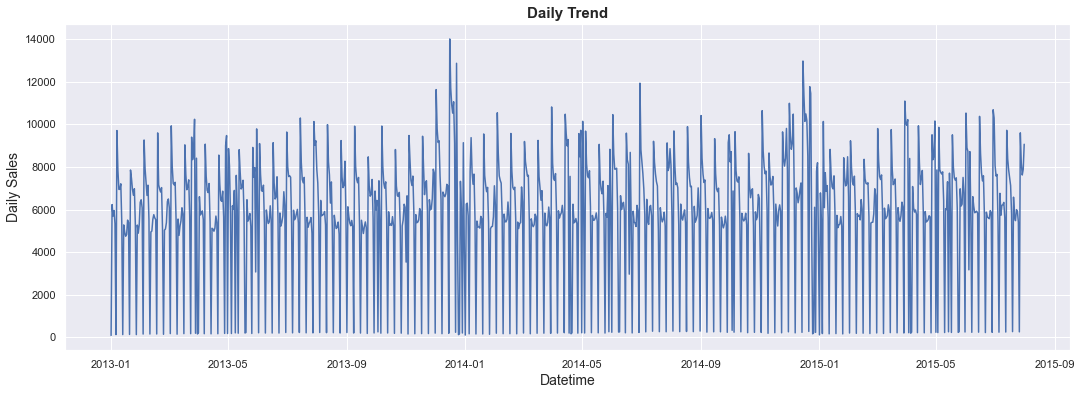

In [128]:
plot_trend(date_df, ['Sales'], 'Daily Trend', "Daily Sales", "Datetime")

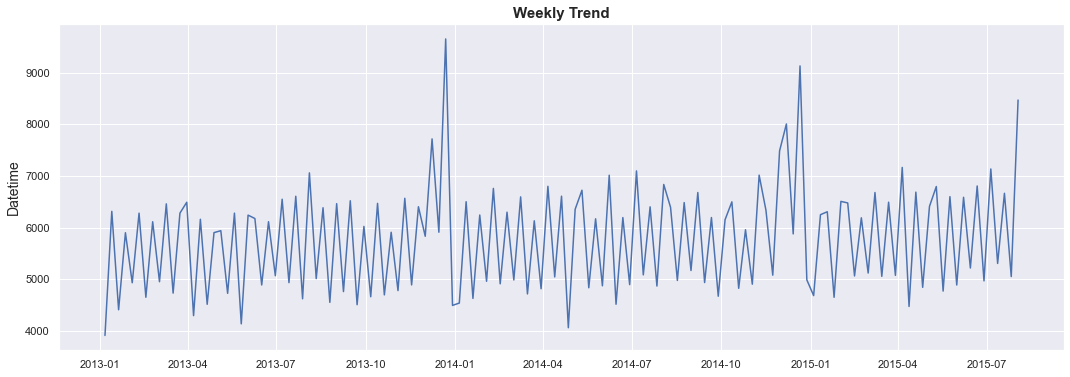

In [124]:
plot_trend(date_df[['Sales']].resample('W').mean(), ['Sales'], 'Weekly Trend', "Weekly Sales", "Datetime")

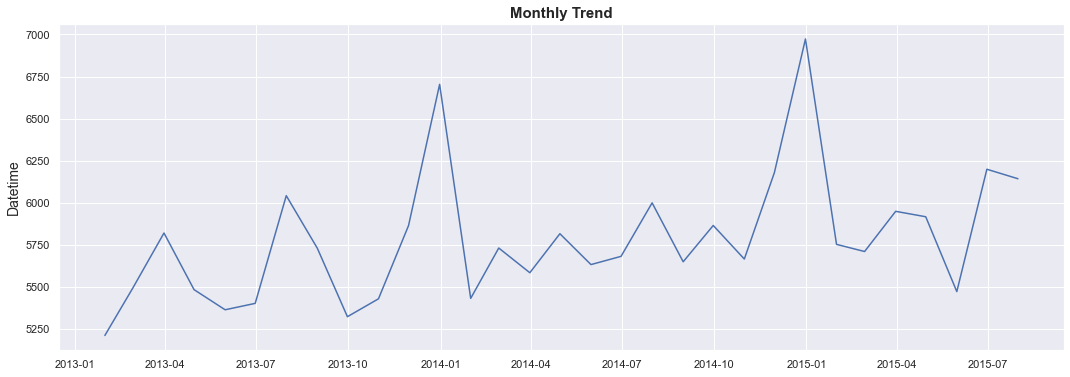

In [125]:
plot_trend(date_df[['Sales']].resample('M').mean(), ['Sales'], 'Monthly Trend', "Monthly Sales", "Datetime")


Now lets look at monthly seasonality across the store types

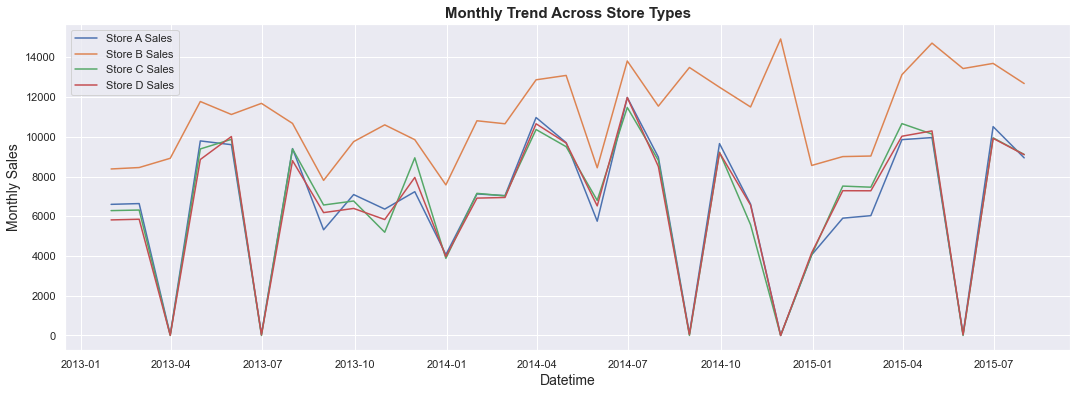

In [135]:
new_df["Store A Sales"] = date_store_type_df['a'][['Sales']]
new_df["Store B Sales"] = date_store_type_df['b'][['Sales']]
new_df["Store C Sales"] = date_store_type_df['c'][['Sales']]
new_df["Store D Sales"] = date_store_type_df['d'][['Sales']]
columns = ["Store A Sales", "Store B Sales", "Store C Sales", "Store D Sales"]
plot_trend(new_df, columns ,'Monthly Trend Across Store Types', "Monthly Sales", "Datetime", labels=columns)

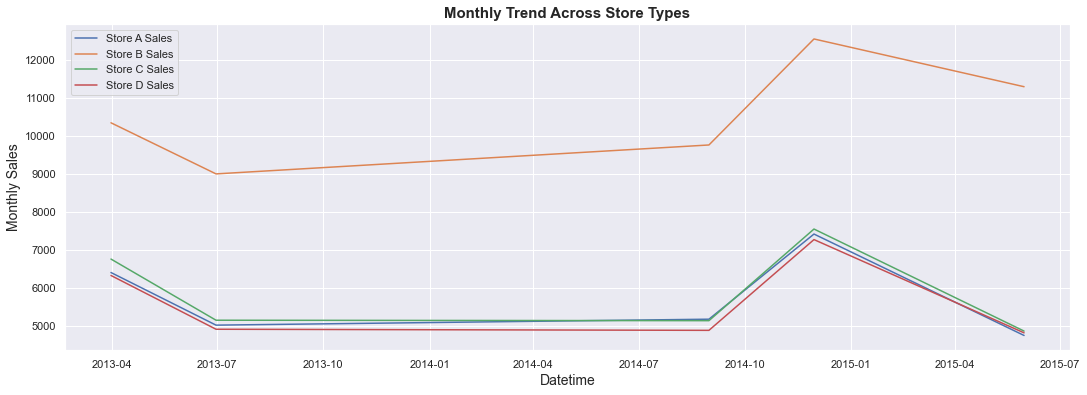

In [136]:
new_df["Store A Sales"] = date_store_type_df['a'][['Sales']].resample('W').mean()
new_df["Store B Sales"] = date_store_type_df['b'][['Sales']].resample('W').mean()
new_df["Store C Sales"] = date_store_type_df['c'][['Sales']].resample('W').mean()
new_df["Store D Sales"] = date_store_type_df['d'][['Sales']].resample('W').mean()
columns = ["Store A Sales", "Store B Sales", "Store C Sales", "Store D Sales"]
plot_trend(new_df, columns ,'Monthly Trend Across Store Types', "Monthly Sales", "Datetime", labels=columns)

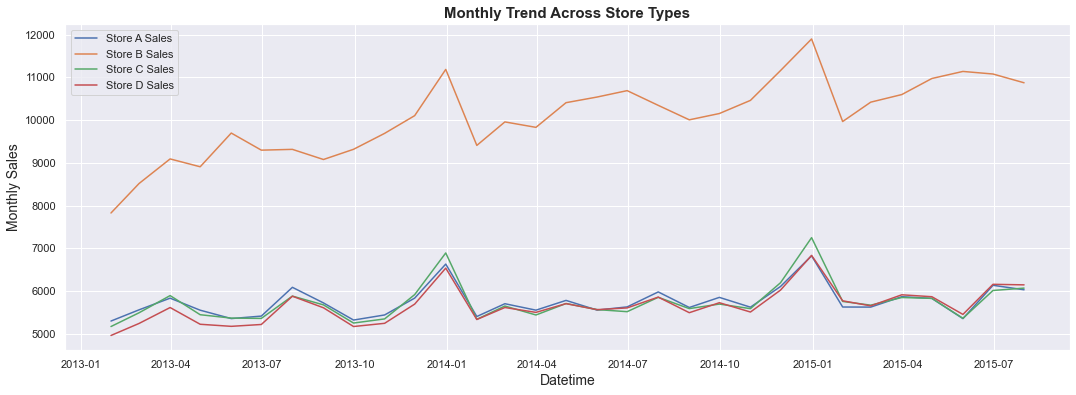

In [137]:
new_df["Store A Sales"] = date_store_type_df['a'][['Sales']].resample('M').mean()
new_df["Store B Sales"] = date_store_type_df['b'][['Sales']].resample('M').mean()
new_df["Store C Sales"] = date_store_type_df['c'][['Sales']].resample('M').mean()
new_df["Store D Sales"] = date_store_type_df['d'][['Sales']].resample('M').mean()
columns = ["Store A Sales", "Store B Sales", "Store C Sales", "Store D Sales"]
plot_trend(new_df, columns ,'Monthly Trend Across Store Types', "Monthly Sales", "Datetime", labels=columns)

Customers count throught the year

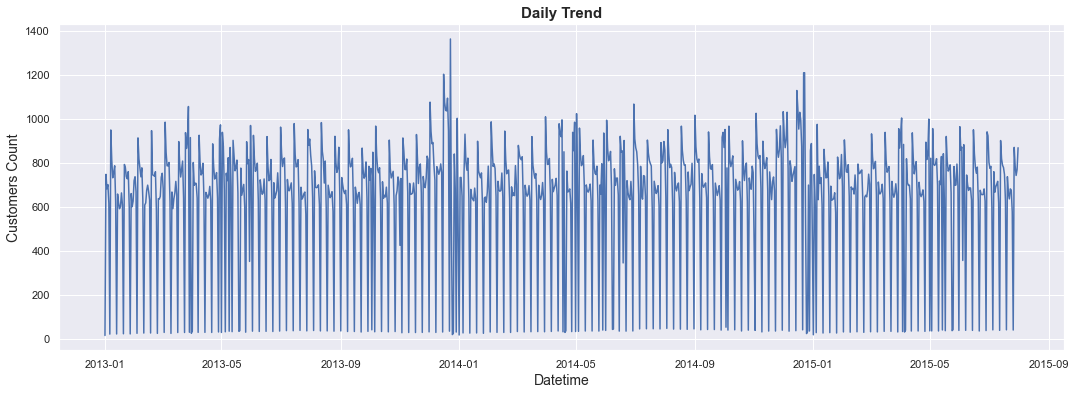

In [138]:
plot_trend(date_df, ['Customers'], 'Daily Trend', "Customers Count", "Datetime")

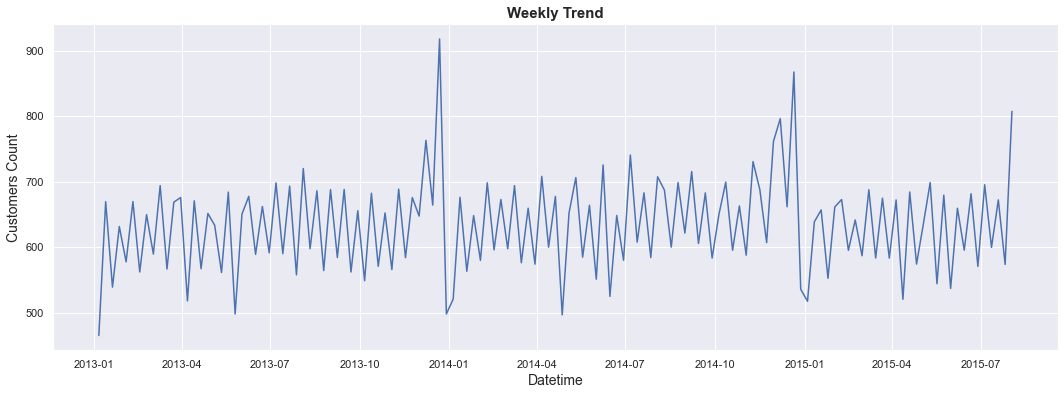

In [139]:
plot_trend(date_df[['Customers']].resample('W').mean(), ['Customers'], 'Weekly Trend', "Customers Count", "Datetime")

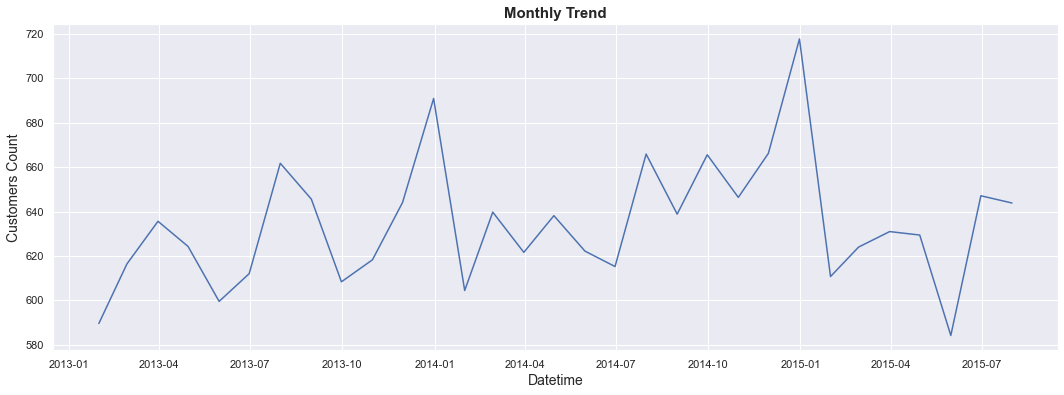

In [140]:
plot_trend(date_df[['Customers']].resample('M').mean(), ['Customers'], 'Monthly Trend', "Customers Count", "Datetime")

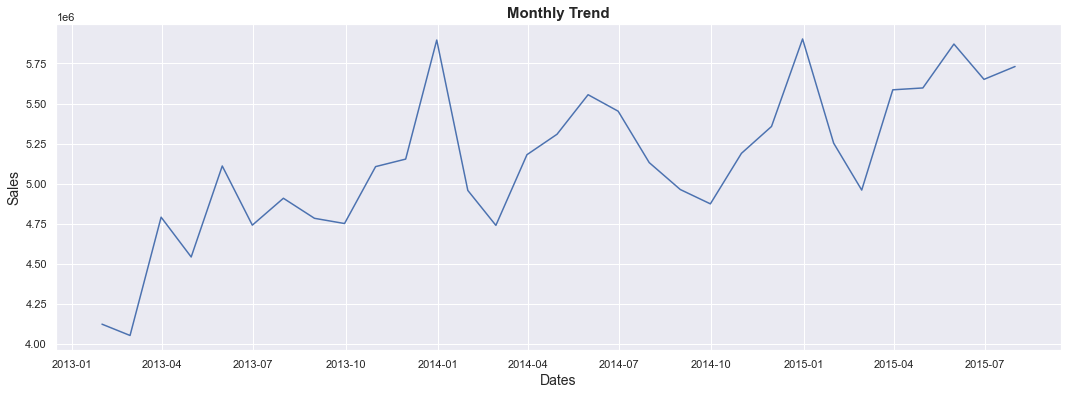

In [89]:
monthly_df = date_store_type_df['b'][["Sales"]].resample('M').sum()
plot_trend(monthly_df, 'Monthly Trend')

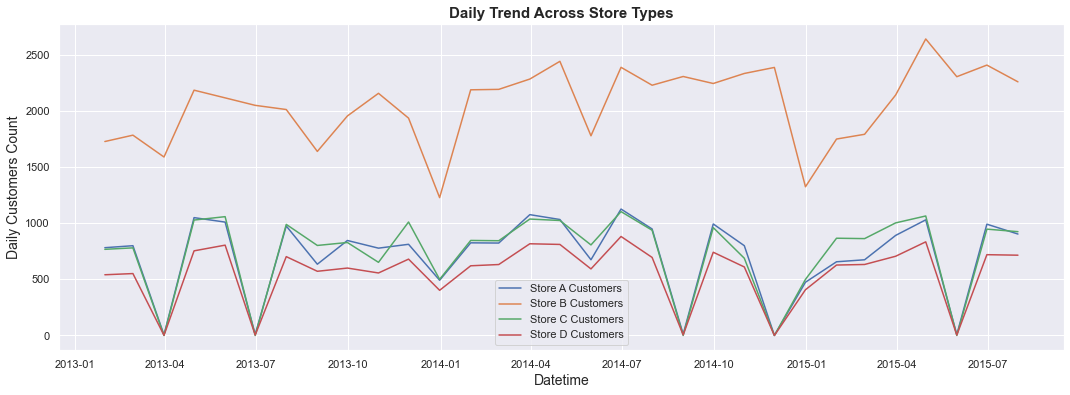

In [143]:
new_df["Store A Customers"] = date_store_type_df['a'][['Customers']]
new_df["Store B Customers"] = date_store_type_df['b'][['Customers']]
new_df["Store C Customers"] = date_store_type_df['c'][['Customers']]
new_df["Store D Customers"] = date_store_type_df['d'][['Customers']]
columns = ["Store A Customers", "Store B Customers", "Store C Customers", "Store D Customers"]
plot_trend(new_df, columns, 'Daily Trend Across Store Types', "Daily Customers Count", "Datetime", labels=columns)

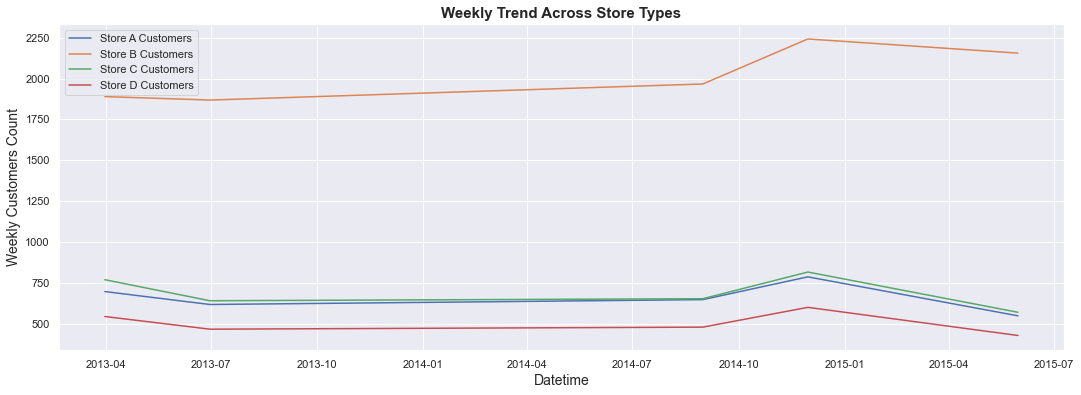

In [144]:
new_df["Store A Customers"] = date_store_type_df['a'][['Customers']].resample('W').mean()
new_df["Store B Customers"] = date_store_type_df['b'][['Customers']].resample('W').mean()
new_df["Store C Customers"] = date_store_type_df['c'][['Customers']].resample('W').mean()
new_df["Store D Customers"] = date_store_type_df['d'][['Customers']].resample('W').mean()
columns = ["Store A Customers", "Store B Customers", "Store C Customers", "Store D Customers"]
plot_trend(new_df, columns, 'Weekly Trend Across Store Types', "Weekly Customers Count", "Datetime", labels=columns)

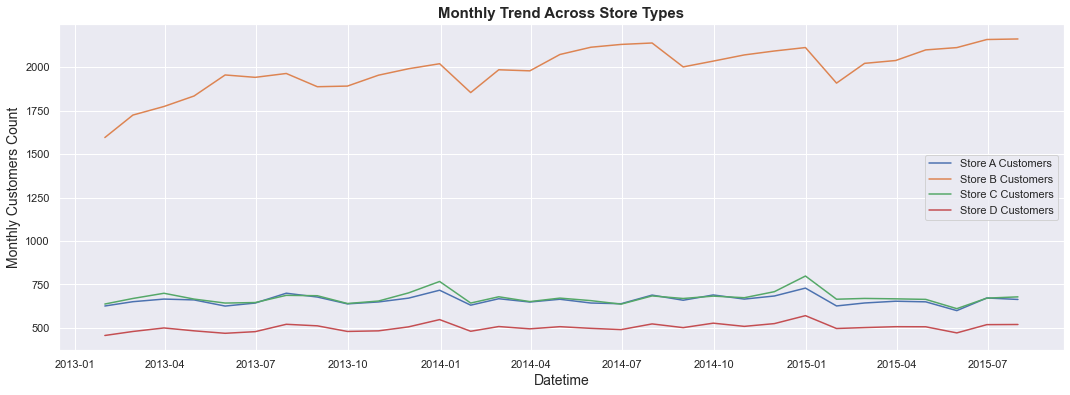

In [145]:
new_df["Store A Customers"] = date_store_type_df['a'][['Customers']].resample('M').mean()
new_df["Store B Customers"] = date_store_type_df['b'][['Customers']].resample('M').mean()
new_df["Store C Customers"] = date_store_type_df['c'][['Customers']].resample('M').mean()
new_df["Store D Customers"] = date_store_type_df['d'][['Customers']].resample('M').mean()
columns = ["Store A Customers", "Store B Customers", "Store C Customers", "Store D Customers"]
plot_trend(new_df, columns, 'Monthly Trend Across Store Types', "Monthly Customers Count", "Datetime", labels=columns)


Seosonality during holidys

In [150]:
train_store_df['StateHoliday'] 


,StateHoliday
0,0
1,0
2,0
3,0
4,0
...,...
1017204,0
1017205,0
1017206,0
1017207,0


In [148]:
date_holiday_type_df = train_store_df.groupby(['Date', 'StateHoliday']).agg(
    {'Customers': 'mean', 'Sales': 'mean'})
date_holiday_type_df = date_store_type_df.unstack().swaplevel(0, 1, 1).sort_index(1)
date_holiday_type_df

ValueError: No axis named 1 for object type Series